# **Project work: A mini segmentation challenge**

<div style="color:#777777;margin-top: -15px;">
<b>Course</b>: MSLS / CO4 |
<b>Version</b>: v1.2 <br><br>
<!-- Date: 10.04.2025 -->
<!-- Comments: Fully refactored. -->
</div>


**Student**: $\Rightarrow$  Alexander Moor, Curdin Bosshart
**Email**: $\Rightarrow$ alexander.moor@students.fhnw.ch, curdin.bosshart@students.fhnw.ch
**University**: $\Rightarrow$  FHNW
**Semester**: $\Rightarrow$  2. Semester
**Date**: $\Rightarrow$  DATE OF SUBMISSION


<br>

## **Abstract**

*$\Rightarrow$ A brief summary of your project in 2-3 sentences.*



<br><br>

----

## **Table of contents**
<!-- Unfortunately, the following does not always work correctly -->
* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)
* [6. Discussion](#sec_discussion)  
* [Appendix: Hints](#sec_hints)  


---

## **Prerequisites / Setup**

$\Rightarrow$ Special setup instructions, imports and configurations go here.


In [2]:
import json
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

---


<a id='sec_dataset'></a>

## **Dataset**

*$\Rightarrow$ Describe your dataset.*

### **Requirements**
* Provide a dataset with at least 10 image samples.
* The dataset must be no larger than 200 MB. If it exceeds this size, please contact the tutor in advance.
* Ensure that you have the rights to use and share the data (check the usage license).
* The images should clearly show a recognizable structure of interest.
* Avoid datasets with too much variation.
* Each student/team must use a different dataset!



---

<a id='sec_preprocessing'></a>

## **Preprocessing**

*$\Rightarrow$ Describe the pre-processing steps applied to enhance the input images.*

*Note: The specific steps will depend on your dataset and the intended application.*

### **Instructions:**
* Improve image quality by reducing noise, adjusting contrast, or normalizing intensity.
* Standardize image dimensions and formats for consistent input to analysis pipelines.
* Highlight or isolate relevant structures to support downstream processing.




---

<a id='sec_manual_segmentation'></a>

## **Manual segmentation**

*$\Rightarrow$ Describe the manual segmentation step*


### **Instructions:**
* Use a suitable tool to manually segment the structures of interest.  
* These segmentations will be needed for further analysis (or model training).  
* If your dataset already includes segmentation masks, you still need to demonstrate how such masks can be created manually.

---

<a id='sec_automated_segmentation'></a>

## **Automated Segmentation**

*$\Rightarrow$ Describe how the images are segmented using Python.*

### **Instructions:**
* Perform the segmentation in Python.
* You may use external libraries or tools (e.g., OpenCV, scikit-image).
* Implement a function `segment(image, ...)` that takes an image as input and returns a segmentation mask for the structure of interest.


In [ ]:
coco_files = [
    'images/downloaded_from_source/train/_annotations.coco.json',
    'images/downloaded_from_source/valid/_annotations.coco.json',
    'images/downloaded_from_source/test/_annotations.coco.json'
]

for coco_path in coco_files:
    print(f"\nInspecting {coco_path}...")
    with open(coco_path, 'r') as f:
        data = json.load(f)

    print(f"- Number of images: {len(data.get('images', []))}")
    print(f"- Number of annotations: {len(data.get('annotations', []))}")
    print(f"- Number of categories: {len(data.get('categories', []))}")

    print("- Categories:")
    for cat in data.get('categories', []):
        print(f"    ID: {cat['id']}, Name: {cat['name']}")
    
    # Check sample image
    if data.get('images'):
        sample_img = data['images'][0]
        print(f"- Example image entry: {sample_img}")
    
    # Check sample annotation
    if data.get('annotations'):
        sample_ann = data['annotations'][0]
        print(f"- Example annotation entry: {sample_ann}")


In [ ]:
merged = {
    'info': {},
    'licenses': [],
    'images': [],
    'annotations': [],
    'categories': []
}

image_id_offset = 0
annotation_id_offset = 0
categories_set = False

for coco_path in coco_files:
    with open(coco_path, 'r') as f:
        data = json.load(f)

    if not categories_set:
        merged['categories'] = data['categories']
        categories_set = True

    # Adjust image IDs
    for img in data['images']:
        original_id = img['id']
        img['id'] = original_id + image_id_offset
        merged['images'].append(img)

    # Adjust annotation IDs + remap image_id links
    for ann in data['annotations']:
        ann['id'] += annotation_id_offset
        ann['image_id'] += image_id_offset
        merged['annotations'].append(ann)

    image_id_offset = max(img['id'] for img in merged['images']) + 1
    annotation_id_offset = max(ann['id'] for ann in merged['annotations']) + 1

# Save merged file
with open('images/unified_image_pool/all_annotations.coco.json', 'w') as f:
    json.dump(merged, f)

print(f"Saved merged COCO file with {len(merged['images'])} images and {len(merged['annotations'])} annotations.")


In [ ]:

# Define folders
folders = [
    'images/downloaded_from_source/train',
    'images/downloaded_from_source/valid',
    'images/downloaded_from_source/test'
]

dest_folder = 'images/unified_image_pool/'
os.makedirs(dest_folder, exist_ok=True)

for folder in folders:
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(folder, file)
            dst = os.path.join(dest_folder, file)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

print(f"Copied all images into {dest_folder}/")


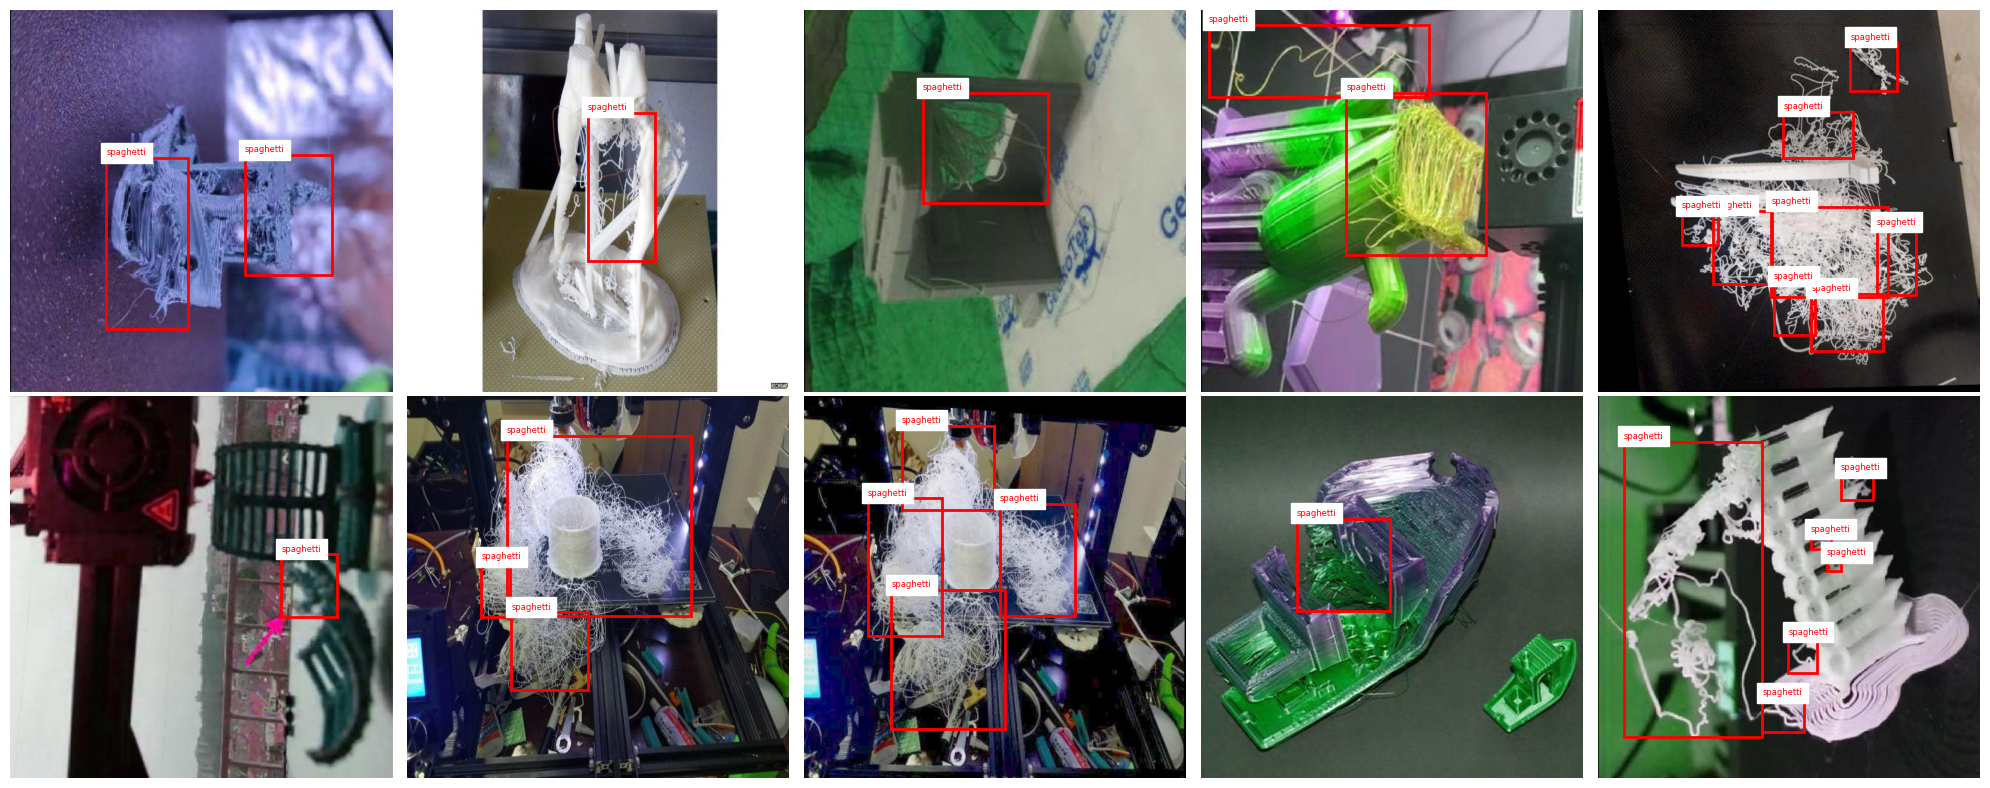

In [ ]:
# Paths
image_folder = 'images/unified_image_pool'
coco_path = 'images/unified_image_pool/all_annotations.coco.json'

# Load COCO data
with open(coco_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Build image_id → annotations map

image_to_anns = defaultdict(list)
for ann in annotations:
    image_to_anns[ann['image_id']].append(ann)

# Pick 10 random images
sample_images = random.sample(images, 10)

# Set up 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, img_info in zip(axes.flatten(), sample_images):
    img_path = os.path.join(image_folder, img_info['file_name'])
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')
    anns = image_to_anns[img_info['id']]

    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']
        label = categories[category_id]

        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            max(bbox[1] - 5, 0),
            label,
            color='red',
            fontsize=6,
            backgroundcolor='white'
        )

plt.tight_layout()
plt.show()


In [2]:
output_mask_folder = 'images/unified_segmentation_masks'

# Create output directory
os.makedirs(output_mask_folder, exist_ok=True)

# Load COCO data
with open(coco_path, 'r') as f:
    coco_data = json.load(f)

# Build image_id → image_info map
image_id_to_info = {img['id']: img for img in coco_data['images']}

# Build image_id → annotations map
image_to_anns = defaultdict(list)
for ann in coco_data['annotations']:
    image_to_anns[ann['image_id']].append(ann)

# Process each image
for image_id, img_info in image_id_to_info.items():
    width = img_info['width']
    height = img_info['height']
    file_name = img_info['file_name']

    # Create blank mask (single-channel, black)
    mask = Image.new('L', (width, height), 0)  # 'L' = grayscale, 0 = black
    draw = ImageDraw.Draw(mask)

    # Draw bounding boxes as white rectangles
    for ann in image_to_anns[image_id]:
        bbox = ann['bbox']  # [x, y, width, height]
        x0 = bbox[0]
        y0 = bbox[1]
        x1 = x0 + bbox[2]
        y1 = y0 + bbox[3]
        draw.rectangle([x0, y0, x1, y1], fill=255)

    # Save mask as PNG
    mask_filename = os.path.splitext(file_name)[0] + '_mask.png'
    mask.save(os.path.join(output_mask_folder, mask_filename))

print(f"Generated masks saved to {output_mask_folder}/")


Generated masks saved to images/unified_segmentation_masks/


**Data Preparation**  
We define a custom PyTorch `Dataset` class called `SpaghettiDataset` to load pairs of images and their corresponding segmentation masks.  
Each image is loaded from disk, converted to RGB format (color channels), and each mask is converted to L mode (grayscale, single channel).  
We apply a resize transform to both images and masks, setting them to 512×512 pixels. This matches the expected input size of the neural network architecture that will follow after this, and ensures consistent dimensions across the dataset.

After loading, we normalize the image pixel values to the [0, 1] range by dividing by 255.  
We then convert the image from shape `(height, width, channels)` to `(channels, height, width)` using `.permute(2, 0, 1)` because PyTorch expects the channel dimension first.  
For the mask, we apply a binary threshold (`> 0.5`) to ensure it’s treated as a foreground/background map, and we add an extra dimension using `.unsqueeze(0)` so it has shape `(1, height, width)`, again matching the expected shape for the network.

We randomly shuffle the full image list and split it into:
- 80% training
- 10% validation
- 10% test

Finally, we wrap these datasets in PyTorch `DataLoader` objects, which handle batching, shuffling, and parallel data loading for efficient training and evaluation.


In [1]:
resize_transform = transforms.Compose([
    transforms.Resize((512, 512)),
])


class SpaghettiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_name)[0] + '_mask.png')

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = resize_transform(image)
        mask = resize_transform(mask)

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

# Directories
image_dir = 'images/unified_image_pool'
mask_dir = 'images/unified_segmentation_masks'

# Collect image filenames
all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(all_files)

# Split into train/val/test
n = len(all_files)
train_files = all_files[:int(0.8 * n)]
val_files = all_files[int(0.8 * n):int(0.9 * n)]
test_files = all_files[int(0.9 * n):]

# Create datasets
train_dataset = SpaghettiDataset(image_dir, mask_dir, train_files)
val_dataset = SpaghettiDataset(image_dir, mask_dir, val_files)
test_dataset = SpaghettiDataset(image_dir, mask_dir, test_files)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")


Train: 572 images
Val: 71 images
Test: 72 images


**Neural Network**  
After some brief research, we discovered U-Net, a purpose built neural network architecture intended specifically for image segmentation. It was published in a paper by [Ronneberger et al. in 2015](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) and appears to have found widespread adoption in the world of image processing. We have decided to use it since it can, apparently, be implemented essentially exactly as presented in the original paper with good to excellent results. The image below was taken from the original publication and shows the architecture of the neural network, which was recreated in code with the help of ChatGPT.

![image](architecture_ronneberger_2025.png)

**How it works**

**Encoder**  
This part takes the big image and gradually compresses it to smaller and smaller feature maps.

- **3×3 convolutions:**  
  Small pattern detectors that slide across the image, looking for things like edges, corners, or textures.

- **Batch normalization:**  
  Keeps the signal values stable, helping the network train faster and more reliably.

- **ReLU activations:**  
  Introduces nonlinearity, allowing the network to learn complex shapes and patterns.

- **Max pooling:**  
  Reduces the size of the image by keeping only the strongest signals, helping the network focus on the most important features and saving computation.

**Bottleneck**  
At the bottom, after all the downsampling, the network has a compressed feature map containing the most abstract, high-level understanding of the input image.

**Decoder**   
This part takes the compressed features and rebuilds them back to the original image size.

- **Transposed convolutions (learned upsampling):**  
  Instead of just stretching the image, the network learns how to fill in new pixels so they best match the patterns it saw during training.

- **Skip connections:**  
  Bring back detailed features (like edges and fine textures) from the encoder, helping the decoder make precise pixel predictions.

The **final 1×1 convolution**  
This takes the last expanded feature map and converts it into a single value per pixel, often a probability, like “how likely is this pixel part of the object we’re segmenting?”


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        up4 = self.up4(bn)
        merge4 = torch.cat([up4, d4], dim=1)
        c4 = self.conv4(merge4)
        up3 = self.up3(c4)
        merge3 = torch.cat([up3, d3], dim=1)
        c3 = self.conv3(merge3)
        up2 = self.up2(c3)
        merge2 = torch.cat([up2, d2], dim=1)
        c2 = self.conv2(merge2)
        up1 = self.up1(c2)
        merge1 = torch.cat([up1, d1], dim=1)
        c1 = self.conv1(merge1)

        out = self.out(c1)
        return out


**Initialization**  
We initialize the U-Net model, specifying 3 input channels (for RGB images) and 1 output channel (for the binary segmentation mask). The model is moved to the appropriate device, using a GPU (`cuda`) if available, or falling back to the CPU.

In [ ]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)

**Loss Function**  
For training, we use the binary cross-entropy with logits loss (`BCEWithLogitsLoss`), which combines a sigmoid activation with binary cross-entropy loss in a single, numerically stable function.  
This is appropriate because our task is a per-pixel binary classification: each pixel in the output mask must be classified as either foreground (object) or background (non-object).  
Since the model outputs a raw score for each pixel, we need to apply a sigmoid function to convert it to a probability between 0 and 1. `BCEWithLogitsLoss` handles this internally and computes the correct loss between the predicted probabilities and the ground truth binary mask.

**Optimizer**  
We optimize the model using the Adam optimizer, which is a popular choice because it automatically adjusts the learning rate for each parameter based on the history of its gradients.  
We set the base learning rate to 0.0001, which controls how large each parameter update step is. Compared to simpler optimizers like stochastic gradient descent (SGD), Adam often leads to faster and more stable convergence.


In [ ]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training**  
We train the model over multiple epochs, where each epoch means the model has seen the entire training dataset once.  
We set a large maximum number of epochs (100), but we also implement **early stopping**: this means we monitor the validation loss after each epoch, and if it stops improving for a fixed number of consecutive epochs (here, `patience = 5`), we stop training early to avoid overfitting and wasting time.

During each epoch:
- We run the model in training mode, compute the loss on each batch of training images, backpropagate the gradients, and update the model weights.
- After finishing all training batches, we evaluate the model on the validation set (without gradient updates) to track how well it generalizes.
- We calculate the average training and validation loss per epoch and print them for monitoring.

If the validation loss improves, we reset the patience counter and save the model checkpoint (`best_model.pth`). If the validation loss stops improving, we count the number of epochs without improvement, and once it reaches the patience threshold, we stop the loop.

This approach helps prevent overfitting and ensures we keep the best-performing model from training.


In [6]:
num_epochs = 100

best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f}")

    # Early stopping check:
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break


Epoch [1/100] Train Loss: 0.4809 Val Loss: 0.4933
Epoch [2/100] Train Loss: 0.4257 Val Loss: 0.4423
Epoch [3/100] Train Loss: 0.4084 Val Loss: 0.4382
Epoch [4/100] Train Loss: 0.3930 Val Loss: 0.4103
Epoch [5/100] Train Loss: 0.3844 Val Loss: 0.4018
Epoch [6/100] Train Loss: 0.3742 Val Loss: 0.4193
Epoch [7/100] Train Loss: 0.3687 Val Loss: 0.3803
Epoch [8/100] Train Loss: 0.3633 Val Loss: 0.3972
Epoch [9/100] Train Loss: 0.3569 Val Loss: 0.4342
Epoch [10/100] Train Loss: 0.3513 Val Loss: 0.3483
Epoch [11/100] Train Loss: 0.3431 Val Loss: 0.5696
Epoch [12/100] Train Loss: 0.3491 Val Loss: 0.3909
Epoch [13/100] Train Loss: 0.3448 Val Loss: 0.3628
Epoch [14/100] Train Loss: 0.3407 Val Loss: 0.3532
Epoch [15/100] Train Loss: 0.3306 Val Loss: 0.3698
Early stopping triggered after 15 epochs.


---

<a id='sec_evaluation'></a>

## **Evaluation**


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize((512, 512)),
])


class SpaghettiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(img_name)[0] + '_mask.png')

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = resize_transform(image)
        mask = resize_transform(mask)

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask
    
# -------- Load geojson mask without rasterio --------
def load_geojson_mask(geojson_path, target_shape):
    """
    Load a geojson file and rasterize it into a binary mask array (without rasterio).
    :param geojson_path: Path to the .geojson file
    :param target_shape: (height, width) tuple
    :return: numpy array (0 or 1) of shape target_shape
    """
    mask_img = Image.new('L', (target_shape[1], target_shape[0]), 0)  # width, height
    draw = ImageDraw.Draw(mask_img)

    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data['features']:
        geom_type = feature['geometry']['type']
        coords_root = feature['geometry']['coordinates']

        if geom_type == 'Polygon':
            polygons = [coords_root]
        elif geom_type == 'MultiPolygon':
            polygons = coords_root
        else:
            continue  # skip unsupported types

        for polygon in polygons:
            exterior = polygon[0]
            # Draw polygon (note: assumes coordinates are already scaled to image size)
            draw.polygon(exterior, outline=1, fill=1)

    return np.array(mask_img)

# -------- Dataset class --------
class HandSegmentedDataset(Dataset):
    def __init__(self, image_dir, geojson_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.geojson_dir = geojson_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        geojson_path = os.path.join(self.geojson_dir, os.path.splitext(img_name)[0] + '.geojson')

        # Load and resize image
        image = Image.open(img_path).convert('RGB')
        image_resized = resize_transform(image)
        image_array = np.array(image_resized) / 255.0

        # Load and rasterize mask
        original_shape = image.size[::-1]  # (height, width)
        gt_mask_array = load_geojson_mask(geojson_path, original_shape)

        # Resize mask to match transformed image size
        gt_mask_pil = Image.fromarray(gt_mask_array.astype(np.uint8) * 255)
        gt_mask_resized = resize_transform(gt_mask_pil)
        mask_array = np.array(gt_mask_resized) / 255.0
        mask_array = (mask_array > 0.5).astype(np.float32)

        # Convert to tensors
        image_tensor = torch.tensor(image_array, dtype=torch.float32).permute(2, 0, 1)
        mask_tensor = torch.tensor(mask_array, dtype=torch.float32).unsqueeze(0)

        return image_tensor, mask_tensor
    
# Directories
image_dir = 'images/unified_image_pool'
mask_dir = 'images/unified_segmentation_masks'
hand_image_dir = 'data_frangi/'
hand_geojson_dir = 'data_frangi/'

hand_files = [f for f in os.listdir(hand_image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
hand_dataset = HandSegmentedDataset(hand_image_dir, hand_geojson_dir, hand_files)
hand_loader = DataLoader(hand_dataset, batch_size=1, shuffle=False)

# Collect image filenames
all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(all_files)

# Split into train/val/test
n = len(all_files)
train_files = all_files[:int(0.8 * n)]
val_files = all_files[int(0.8 * n):int(0.9 * n)]
test_files = all_files[int(0.9 * n):]

# Create datasets
train_dataset = SpaghettiDataset(image_dir, mask_dir, train_files)
val_dataset = SpaghettiDataset(image_dir, mask_dir, val_files)
test_dataset = SpaghettiDataset(image_dir, mask_dir, test_files)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        up4 = self.up4(bn)
        merge4 = torch.cat([up4, d4], dim=1)
        c4 = self.conv4(merge4)
        up3 = self.up3(c4)
        merge3 = torch.cat([up3, d3], dim=1)
        c3 = self.conv3(merge3)
        up2 = self.up2(c3)
        merge2 = torch.cat([up2, d2], dim=1)
        c2 = self.conv2(merge2)
        up1 = self.up1(c2)
        merge1 = torch.cat([up1, d1], dim=1)
        c1 = self.conv1(merge1)

        out = self.out(c1)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=1).to(device)

# Metric functions
def dice_coefficient(pred, target):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou_score(pred, target):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = torch.numel(pred)
    return correct.float() / total


## Important! Run the collapsed cell above if you are doing only evaluation and have not excuted all cells above. Otherwise the model cannot be loaded.

In [17]:
model.load_state_dict(torch.load('best_model.pth'))
# read the markdown cell above if you are getting an error :)

<All keys matched successfully>

**Visual Comparison**  
We evaluate the trained model on the test set by running it in inference mode (using `torch.no_grad()` to disable gradient tracking).  
We load the test images and pass them through the model to get predicted masks.  
The raw model outputs are converted to binary masks by applying a sigmoid activation (to get pixelwise probabilities) and thresholding at 0.5.

For each test image, we plot:
- The original input image.
- The ground truth mask (from the labeled data).
- The predicted mask overlaid on top of the original image.



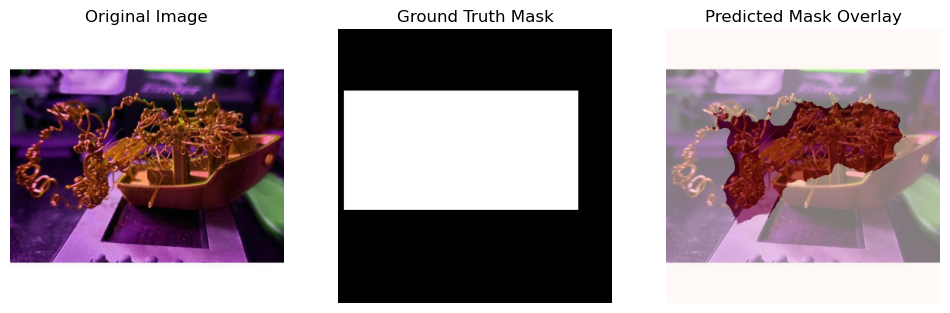

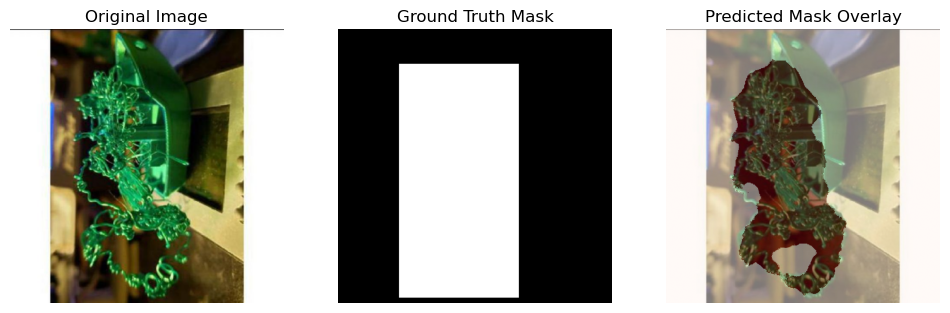

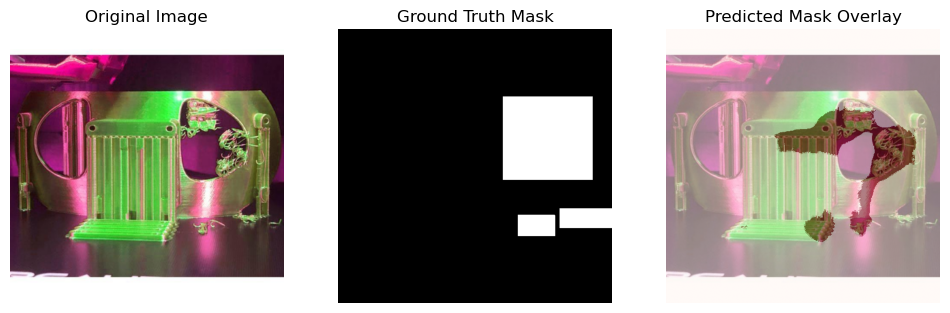

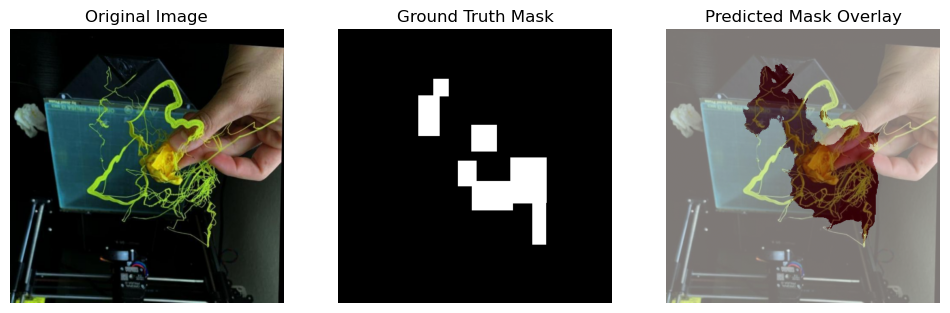

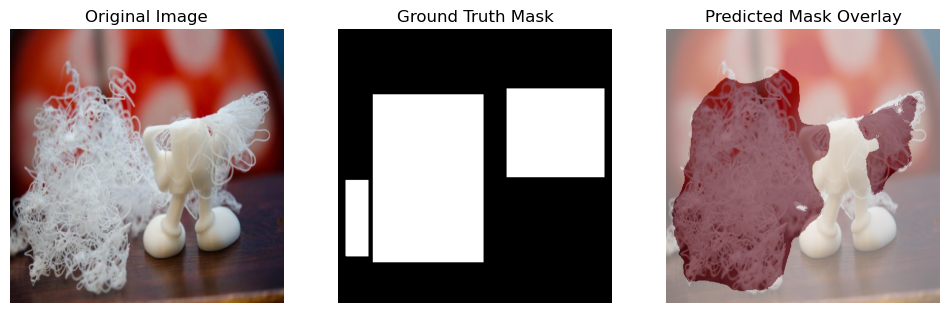

In [24]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load all test indices and shuffle
all_indices = list(range(len(test_dataset)))
random.shuffle(all_indices)

max_plots = 5
plot_count = 0

with torch.no_grad():
    for idx in all_indices:
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        output = model(image)
        pred = torch.sigmoid(output) > 0.5  # Binary mask

        img = image[0].cpu().permute(1, 2, 0).numpy()
        gt_mask = mask.cpu().squeeze().numpy()
        pred_mask = pred[0].cpu().squeeze().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(gt_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask Overlay')
        plt.imshow(img)
        plt.imshow(pred_mask, cmap='Reds', alpha=0.5)
        plt.axis('off')

        plt.show()

        plot_count += 1
        if plot_count >= max_plots:
            break


Based on the limited sample of image versur binary segmentation mask vs model prediction it appears that the model can quite accurately identify the spaghettified areas of a 3d print. We will now quantify this over the whole data set.

**Metrics**

To quantify the accuracy of the model, we use three standard image segmentation metrics:

**Dice Coefficient**  
 This metric measures the overlap between the predicted segmentation mask and the ground truth mask. It ranges from 0 (no overlap) to 1 (perfect match). Mathematically, it is defined as:

$$
\text{Dice} = \frac{2 \times |A \cap B|}{|A| + |B|}
$$

where $A$ is the set of predicted positive pixels and $B$ is the set of ground truth positive pixels.

**Intersection over Union (IoU)**  
Also known as the Jaccard Index, this metric calculates the ratio between the intersection and the union of the predicted and ground truth masks. It provides a more conservative estimate of overlap and is defined as:

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|}
$$

**Pixel Accuracy**  
 This metric measures the proportion of correctly classified pixels over the total number of pixels in the image. It gives an overall accuracy score without focusing specifically on the shape or boundaries of the segments.

In the evaluation, we loop over all images in the test dataset, compute these metrics for each image, and then calculate the mean and standard deviation across the entire dataset. This provides a summary of the model’s average performance and the variability of its predictions.



In [26]:
# Set model to eval mode
model.eval()

# Accumulators
dice_scores = []
iou_scores = []
accuracies = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Binary mask

        # For each image in the batch
        for i in range(images.size(0)):
            pred_mask = preds[i]
            gt_mask = masks[i]

            dice = dice_coefficient(pred_mask, gt_mask)
            iou = iou_score(pred_mask, gt_mask)
            acc = pixel_accuracy(pred_mask, gt_mask)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
            accuracies.append(acc.item())

# Compute averages and standard deviations
avg_dice = np.mean(dice_scores)
std_dice = np.std(dice_scores)

avg_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)

avg_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Model prediction versus presegmented dataset")
print(f"Dice Coefficient: Mean = {avg_dice:.4f}, standard deviation = {std_dice:.4f}")
print(f"IoU Score:  Mean = {avg_iou:.4f}, standard deviation = {std_iou:.4f}")
print(f"Pixel Accuracy:  Mean = {avg_acc:.4f}, standard deviation = {std_acc:.4f}")


Model prediction versus presegmented dataset
Dice Coefficient: Mean = 0.5571, standard deviation = 0.2597
IoU Score:  Mean = 0.4266, standard deviation = 0.2273
Pixel Accuracy:  Mean = 0.8451, standard deviation = 0.1123


The combination of a moderately low dice coefficient as well as IoU score combined with a relatively high pixel accuracy score indicates what was already noticeable in the visualizations: the segmentation masks used for training the model were large rectangles that often covered more area than the actual spaghetti. Therefore it is in fact expected that the union between the model prediction and the segmentation mask is low, given the the assumption that the model has learned the correct patterns.

For a more accurate comparison we will now look at the same metrics as applied to the ten manually segmented images. We would expect that the union metrics improve substantially, given that their segmentation masks follow the true shape of the spaghetti.

In [20]:
dice_scores = []
iou_scores = []
accuracies = []

model.eval()
with torch.no_grad():
    for images, masks in hand_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        pred_mask = preds[0]
        gt_mask = masks[0]

        dice = dice_coefficient(pred_mask, gt_mask)
        iou = iou_score(pred_mask, gt_mask)
        acc = pixel_accuracy(pred_mask, gt_mask)

        dice_scores.append(dice.item())
        iou_scores.append(iou.item())
        accuracies.append(acc.item())

# -------- Report --------
avg_dice = np.mean(dice_scores)
std_dice = np.std(dice_scores)

avg_iou = np.mean(iou_scores)
std_iou = np.std(iou_scores)

avg_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Model prediction versus hand segmented dataset (n=10)")
print(f"Dice Coefficient: Mean = {avg_dice:.4f}, Std = {std_dice:.4f}")
print(f"IoU Score: Mean = {avg_iou:.4f}, Std = {std_iou:.4f}")
print(f"Pixel Accuracy: Mean = {avg_acc:.4f}, Std = {std_acc:.4f}")


[HAND-SEGMENTED] Dice Coefficient: Mean = 0.7520, Std = 0.0826
[HAND-SEGMENTED] IoU Score: Mean = 0.6098, Std = 0.1087
[HAND-SEGMENTED] Pixel Accuracy: Mean = 0.9233, Std = 0.0409


As expected, while the pixel accuracy of the model is slightly higher when comparing against accurately segmented images, the union metrics show a more substantial improvement.

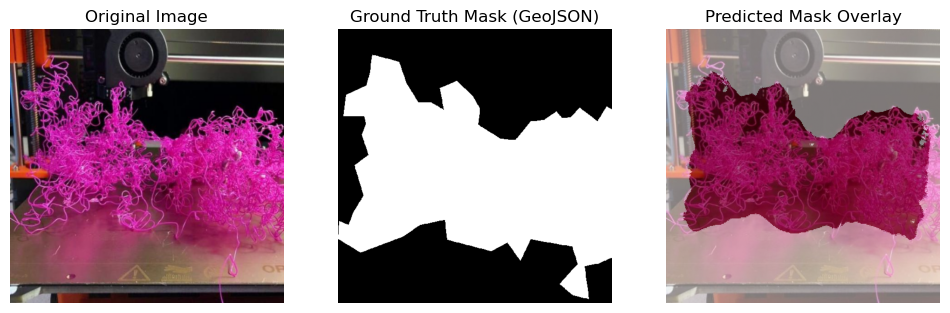

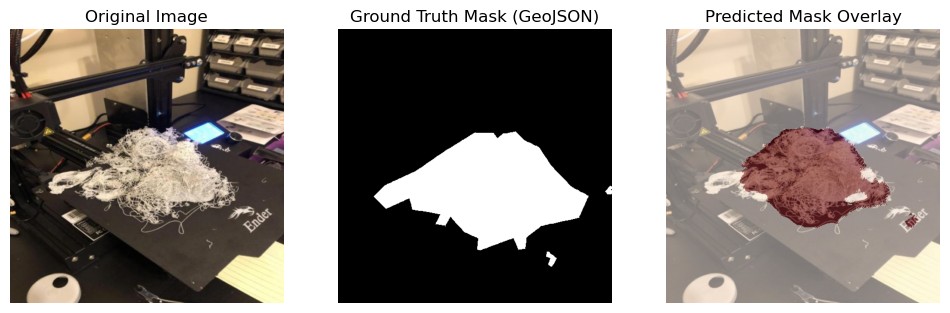

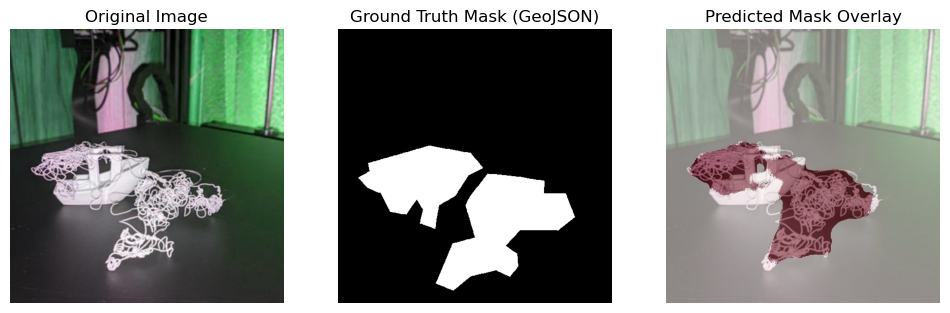

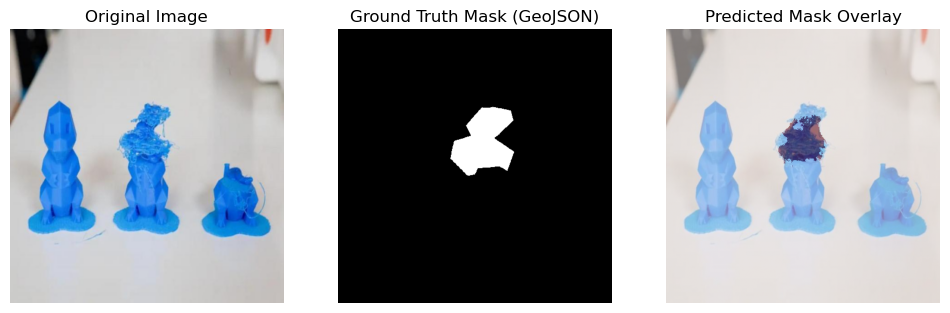

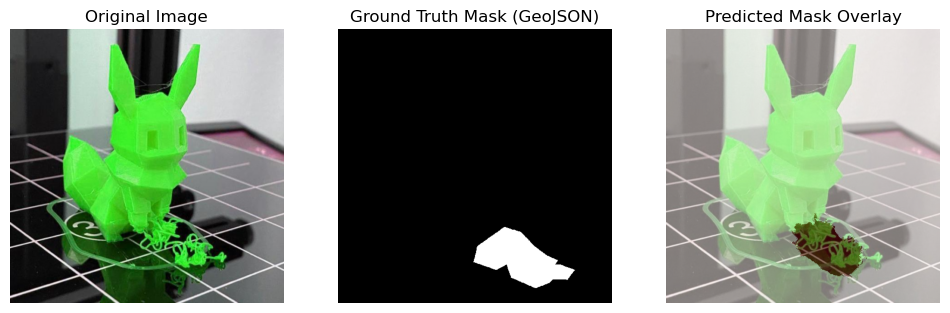

In [15]:
# Load all indices from hand-segmented dataset and shuffle
all_indices = list(range(len(hand_dataset)))
random.shuffle(all_indices)

max_plots = 5
plot_count = 0

model.eval()

with torch.no_grad():
    for idx in all_indices:
        image, mask = hand_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        output = model(image)
        pred = torch.sigmoid(output) > 0.5  # Binary mask

        img = image[0].cpu().permute(1, 2, 0).numpy()
        gt_mask = mask.cpu().squeeze().numpy()
        pred_mask = pred[0].cpu().squeeze().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask (GeoJSON)')
        plt.imshow(gt_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask Overlay')
        plt.imshow(img)
        plt.imshow(pred_mask, cmap='Reds', alpha=0.5)
        plt.axis('off')

        plt.show()

        plot_count += 1
        if plot_count >= max_plots:
            break


These samples are in agreement with the claim made earlier about the behaviour of the union metrics depending on the type of segmentation used.

---

<a id='sec_discussion'></a>

## **Discussion**

*$\Rightarrow$ Briefly discuss your results and share your key observations and your experiences and leaernings.*



---

<a id='sec_references'></a>

## **References**

*$\Rightarrow$ List all relevant references (as URLs).*

*Also, clearly state whether you used generative AI tools (e.g., ChatGPT, GitHub Copilot) and describe how they were used.*



<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## **Appendix: Hints**

### **Markdown / HTML**

The following tutorials might be useful if you are not yet familiar with Markdown:

- [Quick overview](https://www.writethedocs.org/guide/writing/markdown/)
- [Markdown GitHub-style](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
- [More detailed tutorial](https://www.datacamp.com/tutorial/markdown-in-jupyter-notebook)

By the way: In Markdown cells, you can also use simple HTML (e.g., `<key>...</key>` blocks) to gain more control over formatting.





### **Display images**

You may want to display your data, if possible. Here are a few ways to do that:

An easy method for displaying 2D images is using the [**Pillow**](https://pillow.readthedocs.io/en/stable/) library:

In [ ]:
# Option 1: Display an image with Pillow
path = "../data/images/kidney-cells-lowres.jpg"
image = PIL.Image.open(path)
display(image)                  

If you are working with the data as a NumPy array (e.g., when using the OpenCV interface), you can also display it using **matplotlib**.

In [ ]:
# Option 2: OpenCV / Matplotlib
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");

For convenience, we also provide a `display_image()` function in the **tools** library, which includes various utilities used throughout this course.

In [ ]:
# Option 3: Directly display a file
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

<br>
<br>


### **Display overlays**

When segmenting images, you may want to overlay the input image with the segmentation mask.  
There are several ways to do this – here are a few ideas:


In [ ]:
################################################
# Idea 1: Overlay a color on a grayscale image
################################################

# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))

In [ ]:
################################################
# Idea 2: Overlay contours on a grayscale image
################################################

overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize different contours using distinct colors.

#### ***Strategy:***
- Use connected component labeling to assign a unique integer label to each region.
- Map each label to a different color by encoding it in the hue channel (in the HSV color space).
- Extract contours from the mask (ensure the mask is binary).
- Draw the contours with their assigned colors onto the original image.


In [ ]:
################################################
# Idea 3: Use colorized contours
################################################

# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

<br>
<br>



### **How to convert a Jupyter notebook into a HTML/PDF:**

- Don't forget to **save your notebook** before converting!
- Install the conversion tool (if not already installed): `pip install nbconvert`
- Convert the notebook to an HTML file: `jupyter nbconvert --to html main.ipynb`  
  The HTML file will be saved in the same folder as your notebook.
- Open the HTML file in a browser and print (or save) it as a PDF.
- Tip: Using the Opera browser allows you to save the HTML as a single-page PDF, which often produces the best formatting (IMO).


In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb